## hard voting: average of classifiers output
Set the parameter `voting='hard'`

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'mpl'

In [39]:
X,y = make_moons(n_samples=500, noise=0.3, random_state=42);   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_clf = LogisticRegression(solver='lbfgs')
rnd_clf = RandomForestClassifier(n_estimators=100)
svm_clf = SVC(gamma='scale')
voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomF...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [40]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.88
SVC 0.87
VotingClassifier 0.87


## soft voting confidence of classifiers is taken into account
Set the parameter `voting='soft'`

In [41]:
log_clf = LogisticRegression(solver='lbfgs')
rnd_clf = RandomForestClassifier(n_estimators=100)
svm_clf = SVC(gamma='scale', probability=True)
voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft')
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.89
SVC 0.87
VotingClassifier 0.88


# Boosting and Pasting
`BaggingRegressor` for regression. To use pasting instead, just set `bootstrap=False`

In [42]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1);
bag_clf.fit(X_train, y_train);
y_pred = bag_clf.predict(X_test);
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))


0.9


In [43]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.82


In [44]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

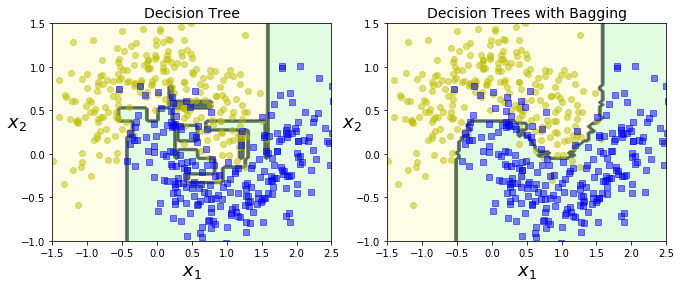

In [45]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
#save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### The ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced.

 Overall, bagging often results in better models, which explains why it is gen‐ erally preferred. However, if you have spare time and CPU power you can use cross- validation to evaluate both bagging and pasting and select the one that works best.
 
 By default a BaggingClassifier samples m training instances with replacement (bootstrap=True), where m is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor.6 The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors.
Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

`oob_score=True` when creating a BaggingClassifier to request an automatic oob evaluation after training.

In [48]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True);
bag_clf.fit(X_train, y_train);
bag_clf.oob_score_

0.91

In [49]:
y_pred = bag_clf.predict(X_test);
accuracy_score(y_test, y_pred)

0.89

`max_samples`: `int` or `float`, optional (default=`1.0`)
The number of samples to draw from X to train each base estimator.
 - If int, then draw `max_samples` samples.
 - If float, then draw `max_samples * X.shape[0]` samples.

#### The BaggingClassifier class supports sampling the features as well. This is controlled by two hyperparameters: `max_features` and `bootstrap_features`. They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling.

It is useful when you are dealing with high-dimensional inputs (such as images). 

 - **Random Patches method**: sampling both training instances and features. 

 - **Random Subspaces**: Keeping all training instances (i.e., `bootstrap=False` and `max_samples=1.0`) and sampling features (i.e., `bootstrap_features=True` and/or `max_features` smaller than `1.0`).

# Random forest
As we have discussed, a Random Forest9 is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set. Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can instead use the `RandomForestClassifier` class, which is more convenient and optimized for Decision Trees (similarly, there is a `RandomForestRegressor` class for regression tasks).

In [53]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)


### the above is equivalent to the below:

In [54]:
bag_clf = BaggingClassifier(
         DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
         n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node (see Chapter 6), it searches for the best feature among a random subset of features. his results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model.

# Extra-trees
It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds.
    A forest of such extremely random trees is simply called an Extremely Randomized Trees ensemble.

# Feature importance of Random Forests
Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.

The value is into the `feature_importances_` variable:

In [55]:
>>> from sklearn.datasets import load_iris
>>> iris = load_iris()
>>> rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
>>> rnd_clf.fit(iris["data"], iris["target"])
>>> for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10195450486906027
sepal width (cm) 0.024743666860746295
petal length (cm) 0.4371389579657719
petal width (cm) 0.4361628703044211


#### Similarly, if you train a Random Forest classifier on the MNIST dataset

In [63]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
    
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

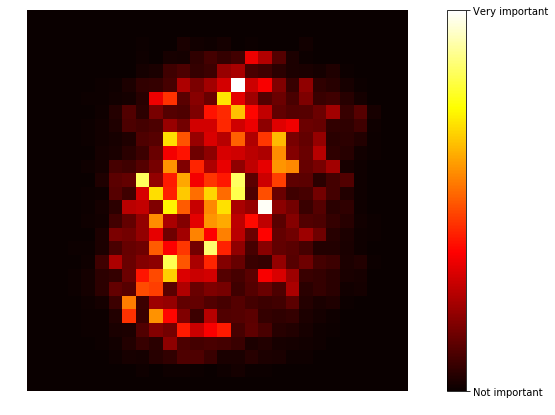

In [66]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plt.figure(figsize=(14,7))
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

#save_fig("mnist_feature_importance_plot")
plt.show()